In [158]:
# https://towardsdatascience.com/coding-neural-network-forward-propagation-and-backpropagtion-ccf8cf369f76
# https://brilliant.org/wiki/backpropagation/
# https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/download/sZAHVX74GzL8DkikkBxh%2Fversions%2FYKMwG6P7QgYwcBBhHi0D%2Ffiles%2Fdata.csv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
#from sklearn import metrics #for making the confusion matrix and finding the accuracy of the model
import gc # to manually activate gc, for more accurate time measurement

In [159]:
df=pd.read_csv("data.csv")
#df stores the raw data from our breast cancer dataset

In [160]:
Y=[]
for i in df["diagnosis"]:
    if i=="M":
        Y.append(1.0)
    else:
        Y.append(0.0)
        
#Y -> stores whether the person has malignant or benign tumor
#Y -> 1 for malignant tumor
#  -> 0 for benign tumor
#shape of Y is (569,1)

In [161]:
Y=pd.DataFrame(Y)

In [162]:
df=df.drop(["diagnosis","id","Unnamed: 32"],axis=1) 
#removing unnecessary columns

# Train & Test split

In [163]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size = 0.2, random_state = 0)
# X_train-> training dataset inputs
# y_train-> training dataset labels
# X_test-> testing dataset inputs
# y_test-> testing dataset labels
# the train-test split size 75%-25% 

In [164]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
# to rest the indexes of the dataframes

In [165]:
class Helper(object):    
    def initialize_parameters(self,layers_dims): # initializes the weights and biases for all the layers
        np.random.seed(1)               
        parameters = {} #parameter is a dictionary dictionary which stores the randomly initialized weights and bias matrix of all the layers
        L = len(layers_dims) #L is no of layers           

        for l in range(1, L):           
            parameters["W" + str(l)] = np.random.randn(
                layers_dims[l], layers_dims[l - 1]) * 0.01  # multiplird by 0.01 so that activation functions work in activated mode
            parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        #asserting to check whether the size of the weights and bias matrix is valid
        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)
    
        return parameters

    def sigmoid(self,Z):
        A = 1 / (1 + np.exp(-Z))
        return A, Z


    def linear_forward(self,A_prev, W, b):
        Z = np.dot(W, A_prev) + b 
        cache = (A_prev, W, b)
        return Z, cache


    def linear_activation_forward(self,A_prev, W, b):

        Z, linear_cache = self.linear_forward(A_prev, W, b)
        A, activation_cache = self.sigmoid(Z)
        assert A.shape == (W.shape[0], A_prev.shape[1])
        # linear cache stores (A_prev,W,b) for that layer and activation cache stores the Z for that layer. This cache dictionary will
        # be later used in the backpropogation part of the code for calculating derivatives.
        cache = (linear_cache, activation_cache)
        return A, cache


    def L_model_forward(self,X, parameters):
        A = X.T                          
        caches = []                     
        L = len(parameters) // 2        
    
        #we iterate over layers 1 to total layers-1
        for l in range(1, L):
            A_prev = A
            A, cache = self.linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)])
            caches.append(cache)
        
        #iterating over the last layer
        AL, cache = self.linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)]) #AL stores the output of the final layer
        caches.append(cache)
        
        assert AL.shape == (1, X.shape[0])
        return AL, caches
        
        
    
    def compute_cost(self,AL, y,cost_type): #cost_type is for choosing between the cross extropy and sum of square error
        m = y.shape[1] 
        #cost_type=0->cross entropy loss
        #cost_type=1->sum of square error
        if cost_type==0:
            cost = - (1 / m) * np.sum(np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
        else:
            cost=1/(m)* np.sum((y-AL)**2)
        return cost
    
    
    def sigmoid_gradient(self,dA, Z):
        A, Z = self.sigmoid(Z)
        dZ = dA * A * (1 - A)
        return dZ
    
    # function to calculate the derivative of the cost function with respect to weight,bias,activation
    def linear_backword(self,dZ, cache): 
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = (1 / m) * np.dot(dZ, A_prev.T) #derivative of cost function w.r.t to weight
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True) #derivative of cost function w.r.t to bias
        dA_prev = np.dot(W.T, dZ) #derivative of cost function w.r.t to activation function[sigmoid of z]

        assert dA_prev.shape == A_prev.shape
        assert dW.shape == W.shape
        assert db.shape == b.shape

        return dA_prev, dW, db


    def linear_activation_backward(self,dA, cache):
        linear_cache, activation_cache = cache
        dZ = self.sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = self.linear_backword(dZ, linear_cache)

        return dA_prev, dW, db

    #function to perform the backpropogation
    def L_model_backward(self,AL, y, caches,cost_type):
        y = y.reshape(AL.shape)
        L = len(caches)
        # grads is a dictionary to store the dA,dW,db for each layer. This dictionary will be used to update the parameters.
        grads = {}

        #cost_type=0-> cross entropy loss
        #cost_type=1-> sum of square error
        if cost_type==0:
            dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))
        else:
            dAL= 2*(AL-y)

        #calculating dA,dW,dB for the final layer
        grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = self.linear_activation_backward(dAL, caches[L - 1])

        #calculating dA,dW,dB for the layers 1 to L-1(in reverse order->backpropogating)
        for l in range(L - 1, 0, -1):
            current_cache = caches[l - 1]
            grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = self.linear_activation_backward(grads["dA" + str(l)], current_cache)

        return grads
    
    
    #function to update the parameters
    def update_parameters(self,parameters, grads, learning_rate):
        L = len(parameters) // 2

        for l in range(1, L + 1):
            #updating weights
            parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
            #updating bias
            parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
        return parameters

In [177]:
# Define the multi-layer model using all the helper functions we wrote before
class MLP(object):
    #PARAMETERS
    #self -> the object being created
    #mode -> to choose between batch gradient descent------>  mode=0
    #                          stochastic gradient descent(online method)------> mode=1   
    #cost_type -> to choose between cross entropy loss------>  cost_type=0
    #                               mean squared error------>  cost_type=1
    #X -> the training set input features
    #y -> the training set input labels
    #layers_dims -> dictionary containing number of neurons in each layer
    #num_iterations -> epoch
    
    def L_layer_model(self, mode, cost_type,
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000,
        print_cost=True,print_graph=True):
        np.random.seed(1)

        # initialize parameters
        h1 = Helper()
        parameters = h1.initialize_parameters(layers_dims)
        #h1.parameters = initialize_parameters(layers_dims)

        # intialize cost list
        cost_list = []

        # mode=0 ----> batch gradient descent
        # mode=1 ----> stochastic greadient descent(online gradient descent)
        if(mode==0):
            for i in range(num_iterations):
                # iterate over L-layers to get the final output and the cache
                AL, caches = h1.L_model_forward(X, parameters)

                # compute cost to plot it
                cost = h1.compute_cost(AL.T, y,cost_type)

                # iterate over L-layers backward to get gradients
                grads = h1.L_model_backward(AL, y.to_numpy(), caches,cost_type)

                # update parameters
                parameters = h1.update_parameters(parameters, grads, learning_rate)

                # append each 100th cost to the cost list
                if (i + 1) % 100 == 0 and print_cost:
                #print(f"The cost after {i + 1} iterations is:" cost)
                    print("iteration :",i,"cost:",cost)

                if i % 100 == 0:
                    cost_list.append(cost)
        else:
            for i in range(num_iterations):
                cost_av = 0
                # iterate over L-layers to get the final output and the cache
                for j in range(len(X)):
                    AL, caches = h1.L_model_forward(X.iloc[j].to_frame().T, parameters)

                    # compute cost to plot it
                    cost = h1.compute_cost(AL.T, y.iloc[j].to_frame().T,cost_type)
                    cost_av = cost_av+cost
                    # iterate over L-layers backward to get gradients
                    grads = h1.L_model_backward(AL, y.iloc[j].to_frame().T.to_numpy(), caches,cost_type)

                    # update parameters
                    parameters = h1.update_parameters(parameters, grads, learning_rate)

                    # append each 100th cost to the cost list
                if (i + 1) % 100 == 0 and print_cost:
#                     print(f"The cost after {i + 1} iterations is:" cost)
                    cost_av = cost_av/len(X)
                    print("iteration :",i,"cost:",cost_av)

                #if i % 100 == 0:
                cost_list.append(cost_av)
                
        # plot the cost curve
        if(print_graph==True):
            %matplotlib notebook
            plt.figure(figsize=(10, 6))
            plt.plot(cost_list)
            plt.xlabel("Iterations (per hundreds)")
            plt.ylabel("Loss")
            plt.title(f"Loss curve for the learning rate = {learning_rate}")
        return parameters    

In [178]:
#function to find the accuracy of the model
def accuracy(X, parameters, y):
    h1 = Helper()
    probs, caches = h1.L_model_forward(X, parameters)
    labels = (probs >= 0.5) * 1
    acc = np.mean(labels == y) * 100
    return acc

In [179]:
#number of neurons in each layer
layers_dims = [X_train.shape[1], 5, 3, 1]

# A model using batch gradient descent and cross entropy loss

In [180]:
#mlp_batch is an object of the MLP class
mlp_batch = MLP()

iteration : 99 cost: 0    299.379387
dtype: float64
iteration : 199 cost: 0    298.074897
dtype: float64
iteration : 299 cost: 0    297.878576
dtype: float64
iteration : 399 cost: 0    297.676874
dtype: float64
iteration : 499 cost: 0    297.413086
dtype: float64
iteration : 599 cost: 0    297.134635
dtype: float64
iteration : 699 cost: 0    296.704538
dtype: float64
iteration : 799 cost: 0    296.167606
dtype: float64
iteration : 899 cost: 0    295.535536
dtype: float64
iteration : 999 cost: 0    294.740949
dtype: float64
iteration : 1099 cost: 0    293.202024
dtype: float64
iteration : 1199 cost: 0    292.487843
dtype: float64
iteration : 1299 cost: 0    289.692399
dtype: float64
iteration : 1399 cost: 0    286.671783
dtype: float64
iteration : 1499 cost: 0    283.296666
dtype: float64
iteration : 1599 cost: 0    279.31461
dtype: float64
iteration : 1699 cost: 0    277.896252
dtype: float64
iteration : 1799 cost: 0    269.042839
dtype: float64
iteration : 1899 cost: 0    265.906467
d

/home/pulkit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


iteration : 2299 cost: 0    223.954165
dtype: float64
iteration : 2399 cost: 0    244.209194
dtype: float64
iteration : 2499 cost: 0    211.730296
dtype: float64
iteration : 2599 cost: 0    204.84581
dtype: float64
iteration : 2699 cost: 0    180.891115
dtype: float64
iteration : 2799 cost: 0    185.387457
dtype: float64
iteration : 2899 cost: 0    164.244836
dtype: float64
iteration : 2999 cost: 0    165.713371
dtype: float64


<IPython.core.display.Javascript object>


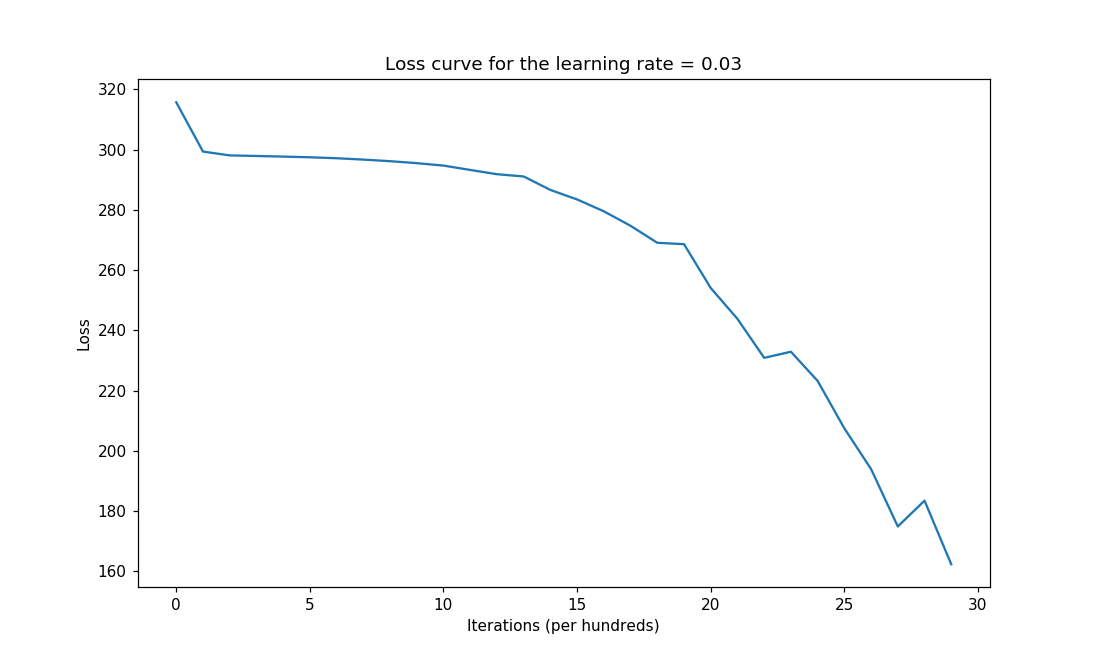

In [181]:
par = mlp_batch.L_layer_model(0,0,X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000)

In [182]:
accuracy(X_test,par, y_test.to_numpy().T)

86.8421052631579

# The accuracy for the batch gradient descent model is 86.84% for 3000 epochs

### Storing prediction time for different epochs for comparison

In [183]:
#storing prediction time and accuracy for different epochs(for making graph to compare the computational efficieny of batch and online gradient descent)
gc.disable()
predictionTime_batch=[]
accuracy_batch=[]
for i in range(30,301,30):
    gc.collect()
    startTime = time.process_time()
    par = mlp_batch.L_layer_model(0,0,X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=i,print_cost=False,print_graph=False)
    endTime = time.process_time()
    predictionTime=endTime - startTime
    predictionTime_batch.append(predictionTime)
    acc=accuracy(X_test,par, y_test.to_numpy().T)
    accuracy_batch.append(acc)
    gc.collect()
gc.enable()

In [185]:
predictionTime_batch

[0.25292260400055966,
 0.6292728379994514,
 0.9374082249996718,
 1.2816657690000284,
 1.5079377029996976,
 1.8862768540002435,
 2.235939799999869,
 2.5300691690008534,
 2.845678444999976,
 3.209211831000175]

# A model using stochastic gradient descent(online) and cross entropy loss

In [188]:
mlp_stochastic = MLP()

<IPython.core.display.Javascript object>


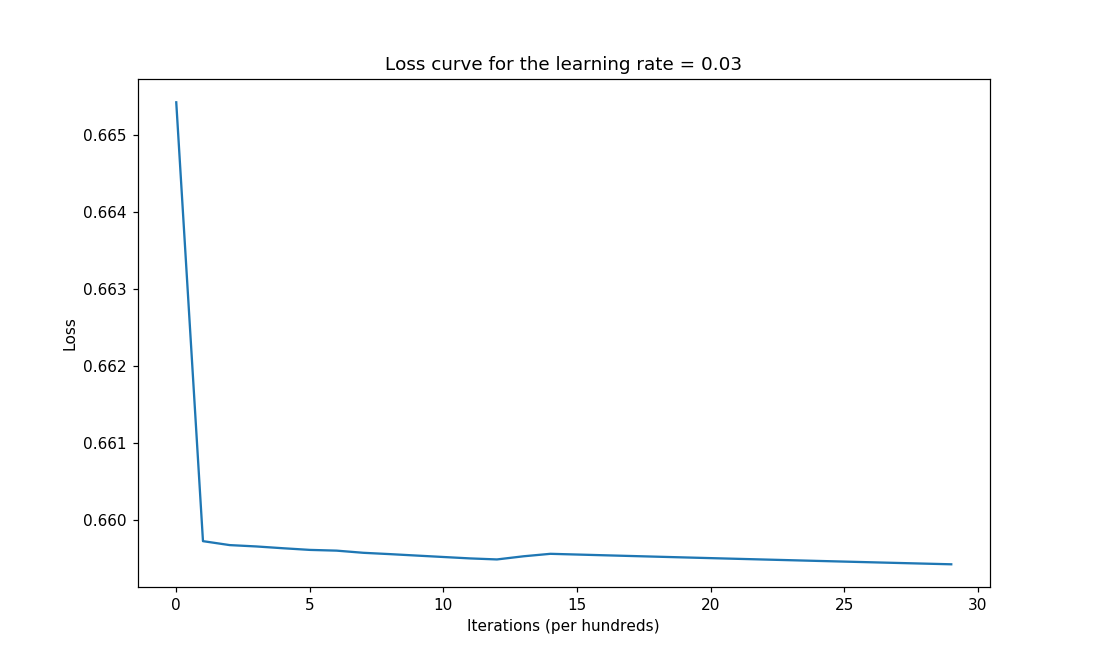

In [147]:
par = mlp_stochastic.L_layer_model(1,0,X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=30)

In [189]:
accuracy(X_test,par, y_test.to_numpy().T)

58.77192982456141

# The accuracy for the online gradient descent model is 58.77% for 30 epochs

### Storing prediction time for different epochs for comparison

In [192]:
gc.disable()
predictionTime_online=[]
accuracy_online=[]

In [193]:
#storing prediction time and accuracy for different epochs(for making graph to compare the computational efficieny of batch and online gradient descent)
for i in range(30,301,30):
    gc.collect()
    startTime = time.process_time()
    par = mlp_stochastic.L_layer_model(1,0,X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=i,print_cost=False,print_graph=False)
    endTime = time.process_time()
    predictionTime=endTime - startTime
    predictionTime_online.append(predictionTime)
    acc=accuracy(X_test,par, y_test.to_numpy().T)
    accuracy_online.append(acc)
    gc.collect()
gc.enable()

In [195]:
predictionTime_online

[63.917447150000044,
 129.532480501,
 188.1726812029999,
 227.019565286,
 302.154805656,
 346.695012614,
 401.03396861600004,
 466.31481045699957,
 508.7178796349999,
 557.2388906899996]

# Graph of Batch vs Online Learning Method for comparing computational accuracy(accuracy vs prediction time)

In [199]:
#x-axis points for the graph
x=[]
for i in range(30,301,30):
    x.append(i)

In [202]:
%matplotlib notebook

<IPython.core.display.Javascript object>


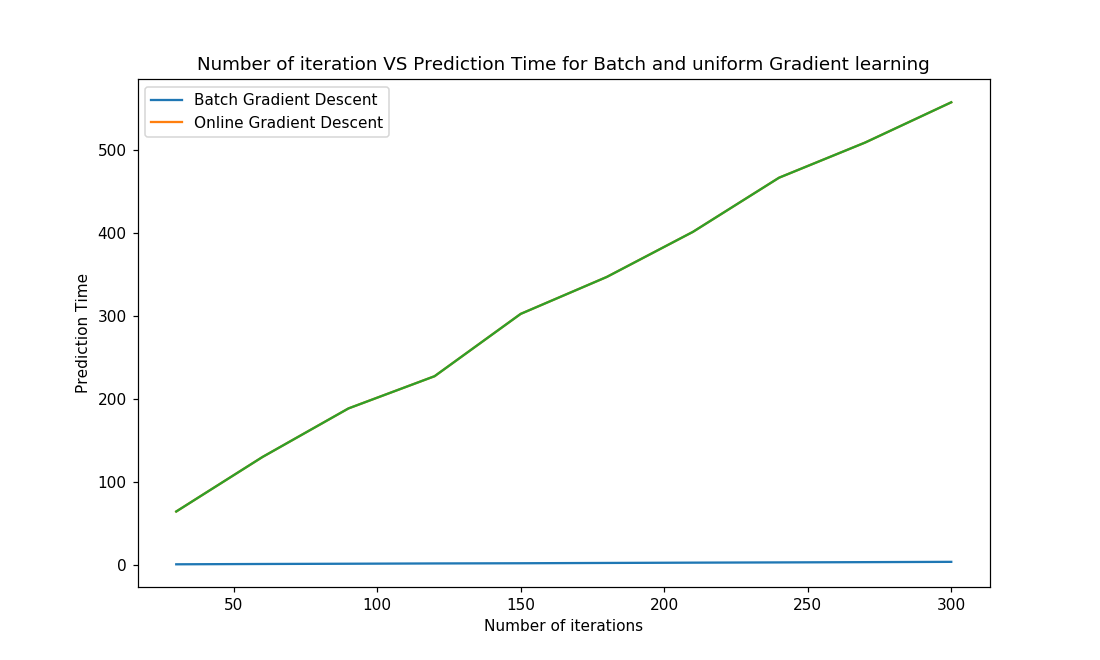

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(x, predictionTime_batch)
plt.plot(x, predictionTime_online)
plt.xlabel("Number of iterations")
plt.ylabel("Prediction Time")
plt.title(f"Number of iteration VS Prediction Time for Batch and uniform Gradient learning")
plt.plot(x, predictionTime_online)
plt.legend(["Batch Gradient Descent", "Online Gradient Descent"])

### In the above graph, we can see that for training the dataset on batch gradient descent(we get almost a strainght line) the prediction time is less as compared to online learning 

# A model using batch gradient descent(online) and mean square error

In [210]:
#mlp_batch is an object of the MLP class
mlp_mse = MLP()

In [ ]:
par = mlp_mse.L_layer_model(0,1,X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000)

iteration : 99 cost: 0    107.57373
dtype: float64
iteration : 199 cost: 0    105.85167
dtype: float64
iteration : 299 cost: 0    105.364971
dtype: float64
iteration : 399 cost: 0    105.21637
dtype: float64
iteration : 499 cost: 0    105.162304
dtype: float64
iteration : 599 cost: 0    105.122929
dtype: float64
iteration : 699 cost: 0    105.087978
dtype: float64
iteration : 799 cost: 0    105.043511
dtype: float64
iteration : 899 cost: 0    104.987209
dtype: float64
iteration : 999 cost: 0    104.91928
dtype: float64
iteration : 1099 cost: 0    104.840245
dtype: float64
iteration : 1199 cost: 0    104.750144
dtype: float64


In [149]:
accuracy(X_test,par, y_test.to_numpy().T)

58.77192982456141